# DBSCAN code tutorial:
In this notebook, we will provide some code example of how to do DBSCAN, Agglomerative, and K-medroids clustering. We will primarily 

## Part 1: DBSCAN Intuition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

In [2]:
##generate a fake dataset. 
##Note that here I intentionally made the std low so it would be a better fit to use DBSCAN as clusterin method!
X, y_true = make_blobs(n_samples=120, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)

print(X.shape)
print(y_true.shape)

(120, 2)
(120,)


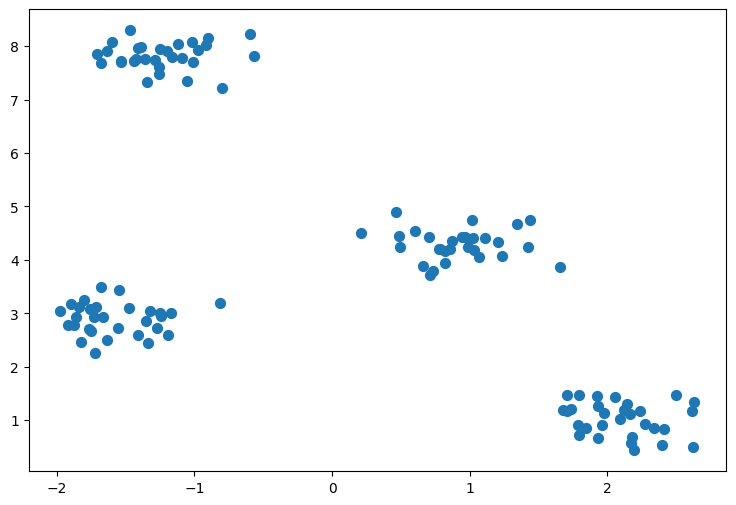

In [3]:
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], s=50);

In [4]:
#run DBSCAN function from sklearn package. Note that Epsilon and min=samples here are chosen arbitrarily 
#so we can test it out and adjust accordingly.
dbscan = DBSCAN(eps=0.3, min_samples=2)
clusters = dbscan.fit_predict(X)

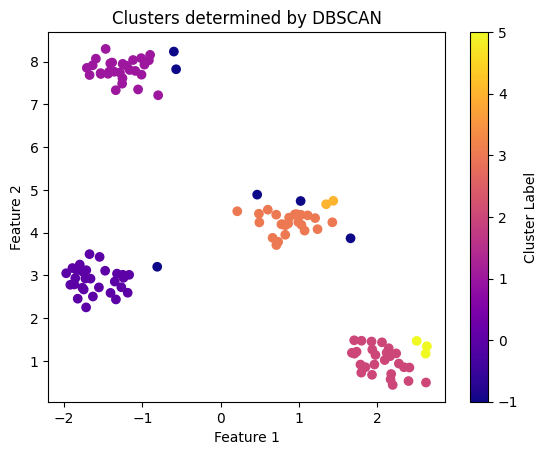

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='plasma')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters determined by DBSCAN')
plt.colorbar(label='Cluster Label')
plt.show()

Note that the above results is not exactly ideal, which is because our parameters are not chosen carefully. Now we adjust the parameters to improve on the result:

In [6]:
new_dbscan = DBSCAN(eps=0.7, min_samples=2)
new_clusters = new_dbscan.fit_predict(X)

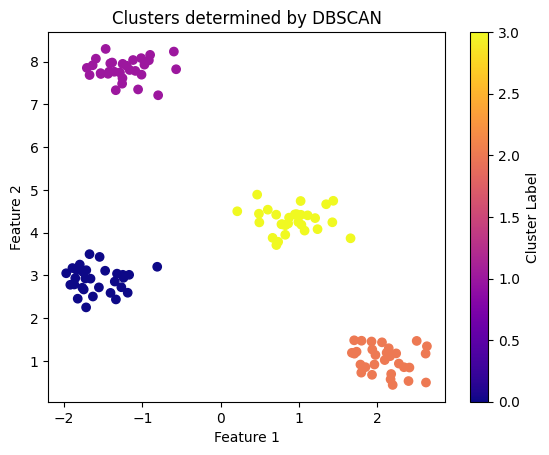

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=new_clusters, cmap='plasma')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters determined by DBSCAN')
plt.colorbar(label='Cluster Label')
plt.show()

## Comparing Time and Quality of DBSCAN vs. other clustering algorithms

We can compare the time complexity of DBSCAN to algorithms we've already been introduced to using the timeit library. First we'll define the previous algorithms (k-means and hierarchical).

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

# def hierarchical_cluster(n):
X, y_true = make_blobs(n_samples=300, 
                    centers=4,
                    cluster_std=0.30, 
                    random_state=0)
Z = linkage(X, 
            method='single', 
            metric='euclidean') 

We specify that we want 4 clusters from the data using SciPy's fcluster function:

In [29]:
# Specifying the number of clusters
num_clusters = 4

# Assigning cluster labels based on the hierarchical clustering results
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

Let's compare the quality of fit to the actual labels using silhouette score.

In [30]:
from sklearn.metrics import silhouette_score

def quality(fit, labels):
    # Evaluate clustering performance
    silhouette_avg = silhouette_score(fit, labels)
    print("Silhouette Score:", silhouette_avg)
quality(X, cluster_labels)

Silhouette Score: 0.8409676710250639


The silhouette score is close to 1, meaning the fit is pretty good.

Now we'll reproduce code for clustering using K-means.

In [32]:
from sklearn.cluster import KMeans

# Code snippet taken from Eni's clustering walkthrough
X, y_true = make_blobs(n_samples=200, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)

kmeans = KMeans(n_clusters=4)  # step 1: initialize the model
kmeans.fit(X)                  # step 2: fit the data to the model
y_kmeans = kmeans.predict(X)   # step 3: prediction

In [33]:
quality(X, y_kmeans)

Silhouette Score: 0.8408057662056734


Finally, we can wrap the previous algorithms into functions and compare their time complexity. We'll time them different input sizes using the timeit library.

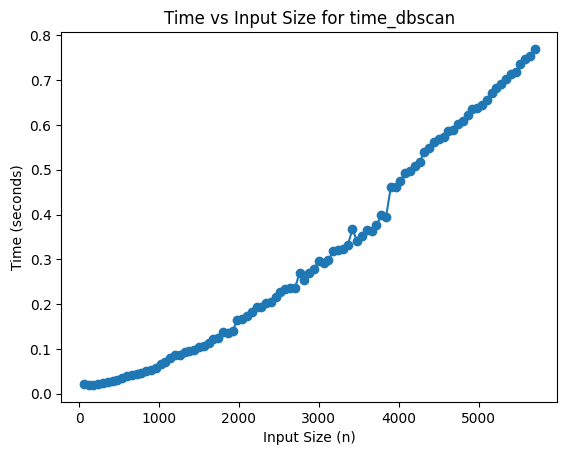

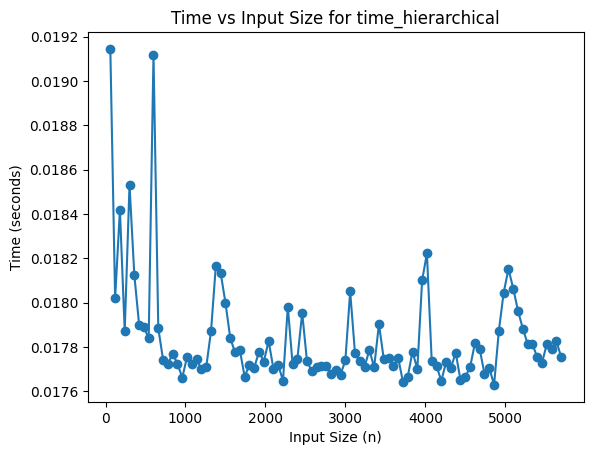

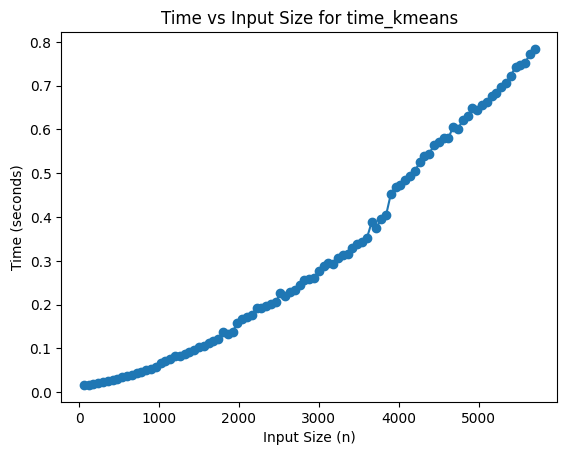

In [41]:
import timeit

def run_dbscan(n):
    X, y_true = make_blobs(n_samples=n, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)
    dbscan = DBSCAN(eps=0.3, min_samples=2)
    clusters = dbscan.fit_predict(X)
    return clusters

def run_k_means(n):
    X, y_true = make_blobs(n_samples=n, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)

    kmeans = KMeans(n_clusters=4)  # step 1: initialize the model
    kmeans.fit(X)                  # step 2: fit the data to the model
    y_kmeans = kmeans.predict(X)   # step 3: prediction
    return y_kmeans

def run_hierarchical(n, num_clusters):
    X, y_true = make_blobs(n_samples=300, 
                    centers=4,
                    cluster_std=0.30, 
                    random_state=0)
    Z = linkage(X, 
                method='single', 
                metric='euclidean') 
    
    # Assigning cluster labels based on the hierarchical clustering results,
    # supposing we know num_clusters ahead of time
    cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
    return cluster_labels

# Define different input sizes
input_sizes = range(60, 2880, 60)

def time_kmeans(inputs):
    # Time the function for each input size
    times = []
    for n in input_sizes:
        time = timeit.timeit(f'run_dbscan({n})', globals=globals(), number=20)
        times.append(time)
    return times

def time_hierarchical(inputs):
    # Time the function for each input size
    times = []
    for n in input_sizes:
        time = timeit.timeit(f'run_hierarchical({n}, 4)', globals=globals(), number=20)
        times.append(time)
    return times

def time_dbscan(inputs):
    # Time the function for each input size
    times = []
    for n in input_sizes:
        time = timeit.timeit(f'run_dbscan({n})', globals=globals(), number=20)
        times.append(time)
    return times

# Plotting
def plot(function):
    plt.plot(input_sizes, function(input_sizes), marker='o')
    plt.title(f'Time vs Input Size for {function.__name__}')
    plt.xlabel('Input Size (n)')
    plt.ylabel('Time (seconds)')
    plt.show()
plot(time_dbscan)
plot(time_hierarchical)
plot(time_kmeans)

Hierarchical clustering is currently fastest, followed by DBSCAN. However, we have hard-coded in that the number of clusters should be 4 for hierarchical, giving it the advantage of not needing to run its course. DBSCAN is slightly faster than K-means, and this is a trend that remains for larger n.

## Part2: DBSCAN for Word Embedding Clustering

We will refenrece the cluster algorithm tutorial notebook Eni posted earlier and use the same example

First let's import/download packages we need for this example. 

In [9]:
import numpy as np
import gensim.downloader as api
from sklearn.cluster import DBSCAN
import sklearn.datasets
from nltk.tokenize import word_tokenize
import nltk

Now, let's read in the dataset.

In [10]:
groups = ['alt.atheism', 'comp.graphics', 'rec.autos', 
          'rec.sport.baseball', 'sci.med', 'talk.politics.guns']


train_data = sklearn.datasets.fetch_20newsgroups(subset='train', categories=groups)
test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)
print(len(train_data.filenames), len(test_data.filenames))
data = test_data.data

3395 2261


In [11]:
len(data)

2261

In [12]:
glove_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [13]:
def document_vector(doc):
    words = [word for word in word_tokenize(doc.lower()) if word in glove_model]
    if len(words) >= 1:
        return np.mean(glove_model[words], axis=0)
    else:
        return np.zeros(glove_model.vector_size)

In [14]:
vectorized = np.array([document_vector(doc) for doc in data])

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/miles/nltk_data'
    - '/home/miles/mini_lecture_clustering/.venv/nltk_data'
    - '/home/miles/mini_lecture_clustering/.venv/share/nltk_data'
    - '/home/miles/mini_lecture_clustering/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [ ]:
vectorized

array([[-0.34143096,  0.38543767,  0.45011032, ..., -0.20311815,
         0.29827112, -0.20402859],
       [-0.18976374,  0.2376265 ,  0.34035814, ..., -0.38422385,
         0.46699592,  0.10311279],
       [-0.18639372,  0.24688265,  0.48327625, ..., -0.32445464,
         0.38292077,  0.0386395 ],
       ...,
       [-0.19741398,  0.28128844,  0.43004102, ..., -0.3578975 ,
         0.42695105,  0.09466117],
       [-0.07582588,  0.17615509,  0.49833387, ..., -0.268992  ,
         0.5821162 , -0.22354624],
       [-0.15395333,  0.40785834,  0.5004178 , ..., -0.5042534 ,
         0.46475044,  0.00366625]], dtype=float32)

First let's arbitrarily determine the parameters for DBSCAN just to see how the code works.

In [15]:
dbscan = DBSCAN(eps=0.001, min_samples=2, metric='cosine')
clusters = dbscan.fit_predict(vectorized)

NameError: name 'vectorized' is not defined

In [17]:
import numpy as np
from collections import Counter

cluster_counts = Counter(clusters)
num_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
num_noise = cluster_counts[-1] if -1 in cluster_counts else 0

print(f"Number of clusters: {num_clusters}")
print(f"Number of noise points: {num_noise}")
print(f"Cluster distribution: {dict(cluster_counts)}")

Number of clusters: 6
Number of noise points: 6
Cluster distribution: {0: 29, 1: 28, 2: 27, 3: 25, -1: 6, 4: 2, 5: 3}


However, we can also use Silhouette Score to help us to decide on the parameters. (Credit to Josie and Sophie!)

In [18]:
from sklearn.metrics import silhouette_score

for eps in np.arange(0.01, 0.1, 0.01):
    model = DBSCAN(eps=eps, min_samples=3, metric='cosine')
    labels = model.fit_predict(vectorized)
    if len(set(labels)) > 1:  # More than 1 cluster plus noise must be present to calculate silhouette
        score = silhouette_score(vectorized, labels)
        print(f"eps: {eps:.1f}, clusters: {len(set(labels))}, silhouette score: {score:.3f}")

NameError: name 'vectorized' is not defined

Given the balance between granularity and silhouette score, eps = 0.3 might be our best option among the provided results, so we will preceed with that as eps. 

In [19]:
min_samples_values = [5, 6, 7, 8, 9, 10]

In [20]:
for min_samples in min_samples_values:
    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.01, min_samples=min_samples, metric="cosine")
    clusters = dbscan.fit_predict(vectorized)

    # Analyze the clusters
    cluster_counts = Counter(clusters)
    num_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
    num_noise = cluster_counts[-1] if -1 in cluster_counts else 0

    # Print the results
    print(f"Results for min_samples={min_samples}:")
    print(f"Number of clusters: {num_clusters}")
    print(f"Number of noise points: {num_noise}")
    print(f"Cluster distribution: {dict(cluster_counts)}\n")


NameError: name 'vectorized' is not defined

## K medoids code example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn_extra.cluster import KMedoids

In [ ]:
##generate a fake dataset

X, y_true = make_blobs(n_samples=120, 
                       centers=4,
                       cluster_std=0.40, 
                       random_state=0)

print(X.shape)
print(y_true.shape)

(120, 2)
(120,)


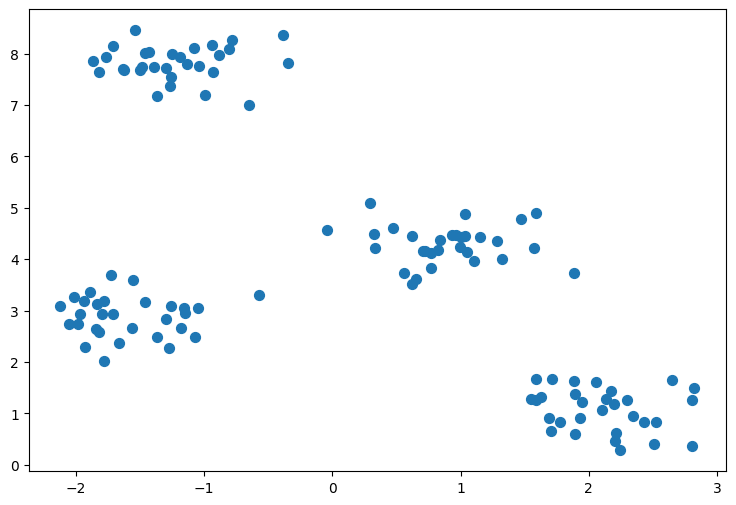

In [ ]:
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], s=50);

In [ ]:
#because this is a fake dataset, we already know that there are 4 clusters.

kmedoids = KMedoids(n_clusters=4, random_state=0)
clusters = kmedoids.fit_predict(X)

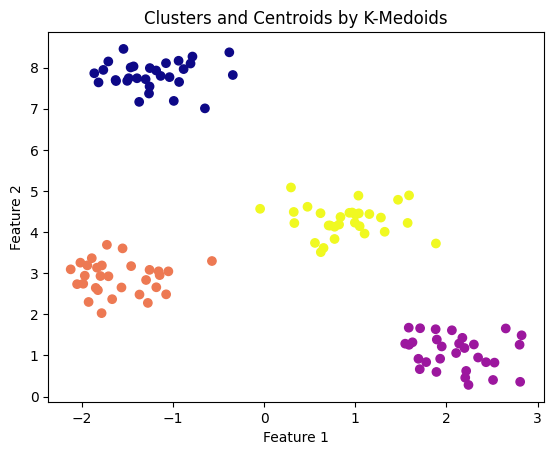

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='plasma')
#plt.scatter(kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1], s=250, marker='*', c='red', label='Centroids')
plt.title('Clusters and Centroids by K-Medoids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()